In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from helpers import plot_bars, cross_validation

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('../data/processed_data/data_2.csv')

In [3]:
df.head()

,CRASH_DATETIME,CASUALTY,FRONT_OR_BACK_ENDED,GOING_STRAIGHT_AHEAD,IN_INTERSECTION,TRUCK_TAXI_BIKE,CLUSTER
0,07/01/2012 10:40,0,0,0,0,0,45
1,07/01/2012 12:18,0,0,0,0,1,25
2,07/01/2012 18:00,0,0,0,0,0,69
3,07/01/2012 19:30,0,0,0,0,0,69
4,07/01/2012 20:00,0,0,0,0,1,58


# Preprocessing

In [4]:
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])

In [5]:
df.groupby(df['CRASH_DATETIME'].dt.hour)['CASUALTY'].agg(['size', 'mean']).sort_values('mean', ascending=False)

,size,mean
CRASH_DATETIME,,
4,3374,0.216064
5,3244,0.214858
3,3448,0.212297
6,4857,0.199918
21,10566,0.197804
2,4103,0.196198
20,12417,0.194169
23,8454,0.188077
22,9856,0.181311


In [6]:
df['IS_NIGHT'] = df['CRASH_DATETIME'].dt.hour.isin([*range(8), *range(19, 25)]).astype(int)

In [7]:
df.groupby(df['CRASH_DATETIME'].dt.day_name().isin(['Saturday', 'Sunday']))['CASUALTY'].mean().sort_values()

CRASH_DATETIME
False    0.155488
True     0.162344
Name: CASUALTY, dtype: float64

In [8]:
X = df.drop(columns=['CRASH_DATETIME', 'CLUSTER', 'CASUALTY'])
y = df['CASUALTY']

kf = StratifiedKFold(shuffle=True, random_state=2022)

# Baseline Model

In [9]:
dummy = cross_validation(X, y, kf, DummyClassifier)
print("5-Fold Cross Validation Average F1-score =", dummy)

5-Fold Cross Validation Average F1-score = 0.0


# Logistic Regression

In [10]:
log = cross_validation(X, y, kf, LogisticRegression)
print("5-Fold Cross Validation Average F1-score =", log)

5-Fold Cross Validation Average F1-score = 0.04980265892647129


In [11]:
log = cross_val_score(LogisticRegression(), X, y, scoring='f1').mean()

# Random Forest

In [12]:
rf = cross_validation(X, y, kf, RandomForestClassifier, n_jobs=-1)
print("5-Fold Cross Validation Average F1-score =", rf)

5-Fold Cross Validation Average F1-score = 0.05500311167459282


In [13]:
rf = cross_val_score(RandomForestClassifier(n_jobs=-1), X, y, scoring='f1').mean()

# Decision Tree

In [14]:
tree = cross_validation(X, y, kf, DecisionTreeClassifier)
print("5-Fold Cross Validation Average F1-score =", tree)

5-Fold Cross Validation Average F1-score = 0.05500311167459282


In [15]:
tree = cross_val_score(DecisionTreeClassifier(), X, y, scoring='f1').mean()

# Ensemble

In [16]:
models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_jobs=-1)),
    ('tree', DecisionTreeClassifier())
]

ensemble = cross_validation(X, y, kf, VotingClassifier, estimators=models)
print("5-Fold Cross Validation Average F1-score =", ensemble)

5-Fold Cross Validation Average F1-score = 0.05500311167459282


In [17]:
ensemble = cross_val_score(VotingClassifier(estimators=models, n_jobs=-1), X, y, scoring='f1').mean()

# Plot the F1 scores

In [18]:
data_to_plot = pd.DataFrame({
    'model': ['Baseline', 'Logistic Regression', 'Random Forest', 'Decision Tree', 'Ensemble'],
    'Scores': [dummy, log, rf, tree, ensemble]}
).sort_values('Scores')

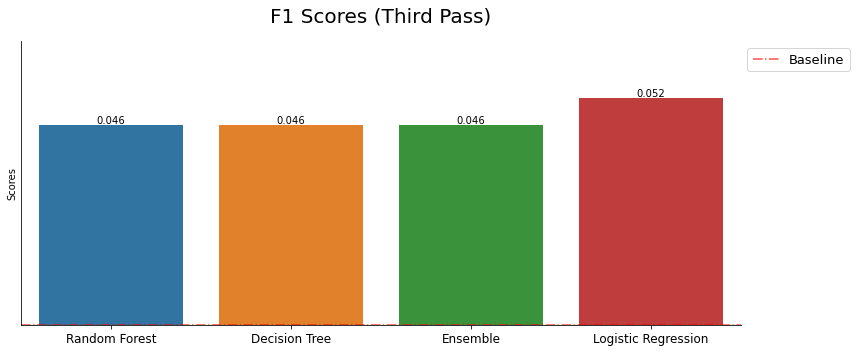

In [19]:
plot_bars(
    x='model', y='Scores', data=data_to_plot.query('model != "Baseline"'), 
    to_filename='third_pass', baseline=data_to_plot.loc[data_to_plot['model'] == "Baseline", 'Scores'].iat[-1], 
    title='F1 Scores (Third Pass)'
)